# Detectron2 Custom Training

<img src="https://dl.fbaipublicfiles.com/detectron2/Detectron2-Logo-Horz.png" width="500">


In [1]:
!ls

Aquarium-Combined-3  coco_eval	config.yml  output


In [2]:
!pip install pyyaml==5.1
!pip install 'git+https://github.com/facebookresearch/detectron2.git'

import torch
TORCH_VERSION = ".".join(torch.__version__.split(".")[:2])
CUDA_VERSION = torch.__version__.split("+")[-1]
print("torch: ", TORCH_VERSION, "; cuda: ", CUDA_VERSION)

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 274.2/274.2 kB 38.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyyaml: filename=PyYAML-5.1-cp39-cp39-linux_x86_64.whl size=44090 sha256=4ed96d3b10526cae9c2a64703c9d9cc9fc4f0a390b8e58fcf9ca81a235f584cf
  Stored in directory: /root/.cache/pip/wheels/68/be/8f/b6c454cd264e0b349b47f8ee00755511f277618af9e5dae20d
Successfully built pyyaml
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 5.4.1
    Uninstalling PyYAML-5.4.1:
      Successfully uninstalled PyYAML-5.4.1
  Cloning https://github.com/facebookresearch/detectron2.git to /tmp/pip-req-build-979gksym
  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/detectron2.git /tmp/pip-req-build-979gksym
  Resolved https://github.com/facebookresearch/detectron2.git to commit c54429b60a64736c8b62002c5729eb818835f745
  Preparing metadata (setup.py) ... done
  Installing build dependencies ... done
  Getting requ

In [3]:
# You may need to restart your runtime prior to this, to let your installation take effect
# Some basic setup:
# Setup detectron2 logger
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

# import some common libraries
import numpy as np
import cv2
import random
import matplotlib.pyplot as plt

# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog
from detectron2.data.catalog import DatasetCatalog
from detectron2.data.datasets import register_coco_instances
import random
from detectron2.utils.visualizer import Visualizer

from detectron2.engine import DefaultTrainer
from detectron2.evaluation import COCOEvaluator
from detectron2.config import get_cfg
#test evaluation
from detectron2.data import DatasetCatalog, MetadataCatalog, build_detection_test_loader
from detectron2.evaluation import COCOEvaluator, inference_on_dataset
import os

In [4]:
class CocoTrainer(DefaultTrainer):

  @classmethod
  def build_evaluator(cls, cfg, dataset_name, output_folder=None):

    if output_folder is None:
        os.makedirs("coco_eval", exist_ok=True)
        output_folder = "coco_eval"

    return COCOEvaluator(dataset_name, cfg, False, output_folder)

In [5]:
# Register the custom dataset
register_coco_instances("my_dataset_train", {}, "./Aquarium-Combined-3/train/_annotations.coco.json", "./Aquarium-Combined-3/train")
register_coco_instances("my_dataset_val", {}, "./Aquarium-Combined-3/valid/_annotations.coco.json", "./Aquarium-Combined-3/valid")
register_coco_instances("my_dataset_test", {}, "./Aquarium-Combined-3/test/_annotations.coco.json", "./Aquarium-Combined-3/test")

WARNING [11/03 04:58:20 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[11/03 04:58:20 d2.data.datasets.coco]: Loaded 4480 images in COCO format from ./Aquarium-Combined-3/train/_annotations.coco.json


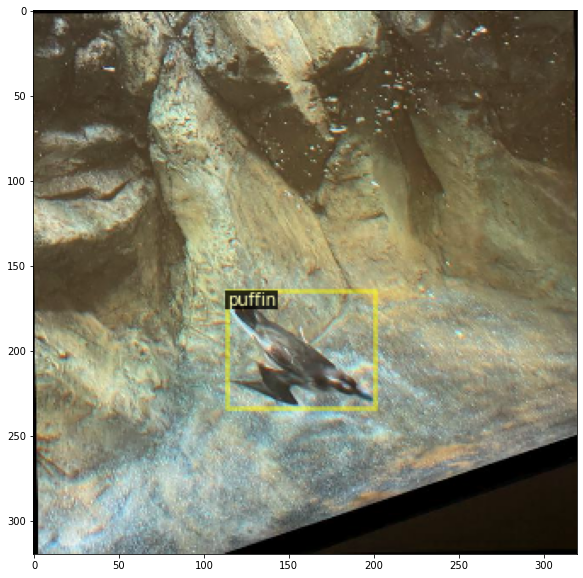

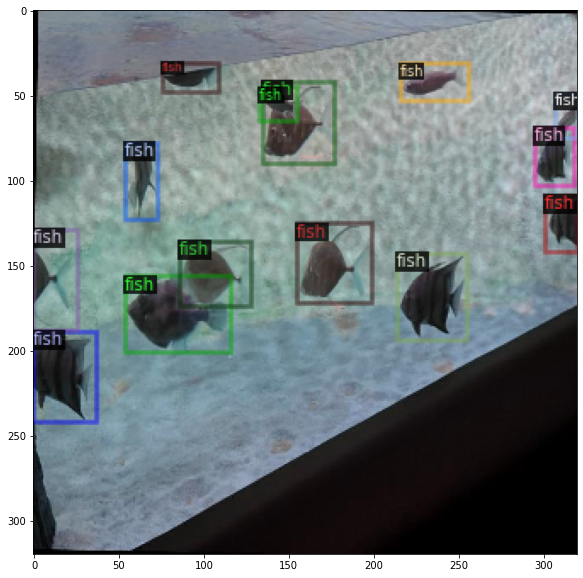

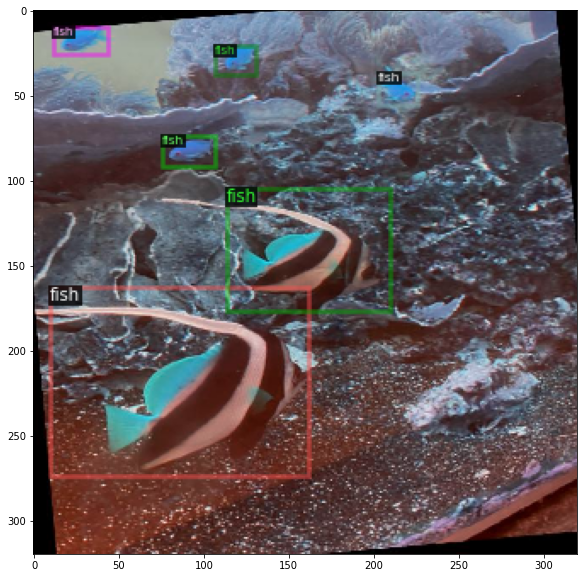

In [6]:
my_dataset_train_metadata = MetadataCatalog.get("my_dataset_train")
dataset_dicts = DatasetCatalog.get("my_dataset_train")

for d in random.sample(dataset_dicts, 3):
    plt.figure(figsize=(10,10))
    img = cv2.imread(d["file_name"])
    visualizer = Visualizer(img[:, :, ::-1], metadata=my_dataset_train_metadata, scale=0.5)
    vis = visualizer.draw_dataset_dict(d)
    plt.imshow(vis.get_image()[:, :, ::-1])

In [7]:
cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-Detection/faster_rcnn_X_101_32x8d_FPN_3x.yaml"))
cfg.DATASETS.TRAIN = ("my_dataset_train",)
cfg.DATASETS.TEST = ("my_dataset_val",)

cfg.DATALOADER.NUM_WORKERS = 2
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-Detection/faster_rcnn_X_101_32x8d_FPN_3x.yaml")  # Let training initialize from model zoo
cfg.SOLVER.IMS_PER_BATCH = 4
cfg.SOLVER.BASE_LR = 0.001


cfg.SOLVER.WARMUP_ITERS = 1000
cfg.SOLVER.MAX_ITER = 8000 #adjust up if val mAP is still rising, adjust down if overfit
cfg.SOLVER.GAMMA = 0.05




cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 64
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 8 #your number of classes + 1

cfg.TEST.EVAL_PERIOD = 500


os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
trainer = CocoTrainer(cfg)
trainer.resume_or_load(resume=True)
trainer.train()

[11/03 04:58:40 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

/usr/local/lib/python3.9/dist-packages/torch/functional.py:478: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ../aten/src/ATen/native/TensorShape.cpp:2894.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


[11/03 04:59:03 d2.utils.events]:  eta: 1:06:25  iter: 1519  total_loss: 0.5032  loss_cls: 0.1286  loss_box_reg: 0.3422  loss_rpn_cls: 0.01915  loss_rpn_loc: 0.02234  time: 0.6234  data_time: 0.0140  lr: 0.001  max_mem: 7211M
[11/03 04:59:16 d2.utils.events]:  eta: 1:06:46  iter: 1539  total_loss: 0.5444  loss_cls: 0.1608  loss_box_reg: 0.3448  loss_rpn_cls: 0.01522  loss_rpn_loc: 0.02251  time: 0.6346  data_time: 0.0057  lr: 0.001  max_mem: 7211M
[11/03 04:59:29 d2.utils.events]:  eta: 1:11:56  iter: 1559  total_loss: 0.5547  loss_cls: 0.1469  loss_box_reg: 0.3576  loss_rpn_cls: 0.0114  loss_rpn_loc: 0.0234  time: 0.6410  data_time: 0.0060  lr: 0.001  max_mem: 7211M
[11/03 04:59:42 d2.utils.events]:  eta: 1:11:55  iter: 1579  total_loss: 0.4812  loss_cls: 0.1164  loss_box_reg: 0.2977  loss_rpn_cls: 0.006292  loss_rpn_loc: 0.02426  time: 0.6443  data_time: 0.0057  lr: 0.001  max_mem: 7211M
[11/03 04:59:55 d2.utils.events]:  eta: 1:09:44  iter: 1599  total_loss: 0.574  loss_cls: 0.1722 

In [ ]:
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.85
predictor = DefaultPredictor(cfg)
evaluator = COCOEvaluator("my_dataset_test", cfg, False, output_dir="./Aquarium-Combined-3/output/")
val_loader = build_detection_test_loader(cfg, "my_dataset_test")
inference_on_dataset(trainer.model, val_loader, evaluator)

In [ ]:
f = open('config.yml', 'w')
f.write(cfg.dump())
f.close()